In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import GaussianNB

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score as accuracy


from sklearn.decomposition import PCA

import spacy

nlp = spacy.load('en_core_web_sm')

from tqdm.auto import tqdm

colors = sns.color_palette("rocket")

In [4]:
df = pd.read_csv('/Users/nazarlenisin/Desktop/Text Segmentation/reviews.csv')
df.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo


In [5]:
class Prior_Data_Analys:
  def __init__(self,df):
    self.df = df


  def shape(self):
    n_samples,n_columns = self.df.shape
    print(f'Number of samples in Data Set: {n_samples}')
    print(f'Number of columns: {n_columns}')

    return n_samples,n_columns


  def unique_columns(self):
    columns = self.df.columns
    print(f'Unique columns:\n')

    for column_idx,column in enumerate(columns):
      print(f'Column {column_idx + 1}: {column}')

    return columns


  def columns_dtypes(self):
    dtypes = self.df.dtypes
    print(f'Dtypes:\n\n {dtypes}')

    return dtypes


  def categorical_features(self):
    print(f'Categorical features:\n')
    categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']

    for feature in categorical_feats:
      print(f'* {feature}')

    return np.array(categorical_feats)


  def numerical_features(self):
    print(f'Numerical features: \n')

    numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
    for feature in numerical_feats:
      print(f'* {feature}')

    return np.array(numerical_feats)


  def group_by(self,feature):
    categorical = self.categorical_features()

    if feature in categorical:
      return df.groupby([feature]).count()

    else:
      return df.groupby([feature]).describe()


  def count_NA(self):
    print(f'Amout of Nans per class:')
    return self.df.isna().sum()


  def duplicates(self):
    print(f'Amount of duplicates: {self.df.duplicated().sum()}')

  def item(self,index):
    print(f'Object number: {index}')

    return self.df.iloc[index]

  def unique_values(self,feature):
    data = self.df[feature]

    values = data.values
    unique_values = np.unique(values)
    print(f'Unique values of {feature}: {unique_values}')

    return unique_values

In [6]:
class Distribution:
  def __init__(self,df,target_feature):
    self.df = df
    self.target_feature = target_feature
    self._eda = Prior_Data_Analys(self.df)


  def distribution_of_target_feature(self):
    for visualization in range(2):
      plt.figure(figsize = (10,10))
      plt.subplot(2,1,visualization + 1)
      if visualization == 0:
        sns.histplot(data = self.df,x = self.target_feature,color = colors[3])
        plt.title(f'Distribution of Target feature: {self.target_feature}')
        plt.show()

      else:
        sns.boxplot(x = self.df[self.target_feature],color = colors[3])
        plt.title(f'Distribution of Target feature: {self.target_feature}')
        plt.show()


  def distribution_of_numerical_features(self):
    numerical_features = self._eda.numerical_features()

    for feature_idx,feature in enumerate(numerical_features):
      plt.figure(figsize = (15,15))
      plt.subplot(len(numerical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.histplot(data = self.df,x = feature,color = colors[1])
      plt.title(f'Distibution of {feature}')
      plt.tight_layout
      plt.show()


  def distribution_of_categorical_features(self,top_k = 5):
    categorical_features = self._eda.categorical_features()
    plt.figure(figsize = (20,20))

    for feature_idx,feature in enumerate(categorical_features):

      values = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False).values[:top_k]
      labels = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False).index[:top_k]

      data_dict = {'Labels': labels, 'Values': values}
      data = pd.DataFrame(data_dict)

      plt.subplot(len(categorical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.barplot(data = data,y = 'Labels',x = 'Values',color = colors[-1])
      plt.title(f'Top {top_k} {feature} by count')

    plt.tight_layout()
    plt.show()

  def relation_numerical_feats_to_target_feat(self):
    numerical_features = self._eda.numerical_features()

    data = df[numerical_features]
    corr = data.corr()

    return sns.heatmap(corr,annot = True, cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))

  def relation_categorical_feats_to_target_feat(self,top_k = 3):
    categorical_features = self._eda.categorical_features()
    plt.figure(figsize = (20,20))

    for feature_idx,feature in enumerate(categorical_features):

      feats = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False)[:top_k].index

      data = self.df
      data = data[data[feature].isin(feats)]

      plt.subplot(len(categorical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.stripplot(data = data, x = feature, y = self.target_feature,hue = feature)
      plt.title(f'Relation between {feature} (top {top_k}) & {self.target_feature}')

    plt.tight_layout()
    plt.show()

In [7]:
class Text_Tokenization:
  def __init__(self,nlp):
    self.nlp = nlp

  def _spacy_tokenizer(self,doc):
    return [token.lemma_ for token in self.nlp(doc)]

  def tokenize(self,doc,max_len,Vocab = None):
    tokenized_texts = []
    vocab = {}

    if Vocab == None:
      for text in doc:
        tokenized_text = []
        text = self._spacy_tokenizer(text)

        for token_idx,token in enumerate(text):
          if token not in vocab.keys():
            vocab[token] = token_idx

          tokenized_text.append(vocab[token])

        if len(tokenized_text) > max_len:
          tokenized_text = tokenized_text[:max_len]

        elif len(tokenized_text) < max_len:
          while len(tokenized_text) != max_len:
            tokenized_text.append(0)

        tokenized_texts.append(np.array(tokenized_text))

      vocab['<unk>'] = 1
      vocab['<pad>'] = 0
      self.vocab = vocab

      return np.array(tokenized_texts)

    else:
      for text in doc:
        text = self._spacy_tokenizer(text)

        tokenized_text = [Vocab[token] if token in Vocab.keys() else Vocab['<unk>'] for token in text]
        if len(tokenized_text) > max_len:
          tokenized_text = tokenized_text[:max_len]

        elif len(tokenized_text) < max_len:
          while len(tokenized_text) != max_len:
            tokenized_text.append(Vocab['<pad>'])

        tokenized_texts.append(np.array(tokenized_text))

      return np.array(tokenized_texts)

In [8]:
class Train_model:
  def __init__(self,model,metric,X_train,y_train,X_test = None,y_test = None,params = None,grid_search = None):
    self.model = model
    self.metric = metric

    self.X_train = X_train
    self.y_train = y_train

    self.X_test = X_test
    self.y_test = y_test

    self.params = params

    self.grid_search = grid_search

  def fit(self):
    if self.grid_search == None or self.params == None:
      print(f'Model: {self.model}')
      print(f'X for train n_samples: {self.X_train.shape[0]}')
      print(f'X for train n_features: {self.X_train.shape[1]}\n')

      self._fit_model = self.model.fit(self.X_train,self.y_train)
      y_pred = self._fit_model.predict(self.X_train)

      metric_score = self.metric(self.y_train,y_pred)
      print(f'{self.metric} on Train Data: {metric_score}')

      return self._fit_model


    else:
      print(f'Model: {self.model}')
      print(f'X for train n_samples: {self.X_train.shape[0]}')
      print(f'X for train n_features: {self.X_train.shape[1]}\n')
      
      grid_search = self.grid_search(self.model,self.params)
      
      self._fit_model = grid_search.fit(self.X_train,self.y_train)
      y_pred = self._fit_model.predict(self.X_train)

      metric_score = self.metric(self.y_train,y_pred)
      print(f'{self.metric} on Train Data: {metric_score}')

      return self._fit_model

  def eval(self):
    y_pred = self._fit_model.predict(self.X_test)
    metric_score = self.metric(self.y_test,y_pred)

    print(f'{self.metric} on Test Data: {metric_score}\n\n')

    return metric_score

In [9]:
class Optimal_model:
  def __init__(self,models,metric,X_train,y_train,X_test,y_test,params = None):
    self.models = models
    self.metric = metric

    self.X_train = X_train
    self.y_train = y_train

    self.X_test = X_test
    self.y_test = y_test

    self.params = params

    self.test_metric_scores = []

  def fit(self):
    for model in self.models:
      print(f'\nModel: {model}')
      Trainer = Train_model(model,self.metric,self.X_train,self.y_train,self.X_test,self.y_test,self.params)
      print(f'Trainer: {Trainer}')

      Trainer.fit()
      metric_score = Trainer.eval()

      self.test_metric_scores.append(metric_score)

    return self.test_metric_scores
  
  def optimal(self):
    optimal_model_idx = np.argmax(self.test_metric_scores)
    model =  self.models[optimal_model_idx]
    print(f'\nOptimal model with best {self.metric} score ({self.test_metric_scores[optimal_model_idx]}): {model}\n')

    return model

In [10]:
def Predict(review,model):
  tokenized_review = tokenizer.tokenize([review],max_len = max_len,Vocab = vocab)

  prediction = model.predict(tokenized_review)
  print(f'Prediction: {prediction}')

  label_class = 'negative' if prediction == 0 else 'positive'
  print(f'{review} - {label_class}')

  return label_class

In [11]:
scores = df['score'].values

sentiment = np.where(scores < 3,0,1)
df['sentiment'] = sentiment

In [12]:
df = df[['content','sentiment']]
df.head(3)

,content,sentiment
0,I cannot open the app anymore,0
1,I have been begging for a refund from this app...,0
2,Very costly for the premium version (approx In...,0


In [13]:
target_feature = 'sentiment'

eda = Prior_Data_Analys(df)
data_visualization = Distribution(df,target_feature)

In [14]:
eda.shape()

Number of samples in Data Set: 12495
Number of columns: 2


(12495, 2)

In [15]:
eda.unique_columns()

Unique columns:

Column 1: content
Column 2: sentiment


Index(['content', 'sentiment'], dtype='object')

In [16]:
eda.columns_dtypes()

Dtypes:

 content      object
sentiment     int64
dtype: object


content      object
sentiment     int64
dtype: object

In [17]:
eda.categorical_features()

Categorical features:

* content


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_45139/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_45139/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']


array(['content'], dtype='<U7')

In [18]:
eda.numerical_features()

Numerical features: 

* sentiment


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_45139/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_45139/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']


array(['sentiment'], dtype='<U9')

In [19]:
eda.count_NA()

Amout of Nans per class:


content      0
sentiment    0
dtype: int64

In [20]:
eda.duplicates()
df = df[df.duplicated() == False]

Amount of duplicates: 659


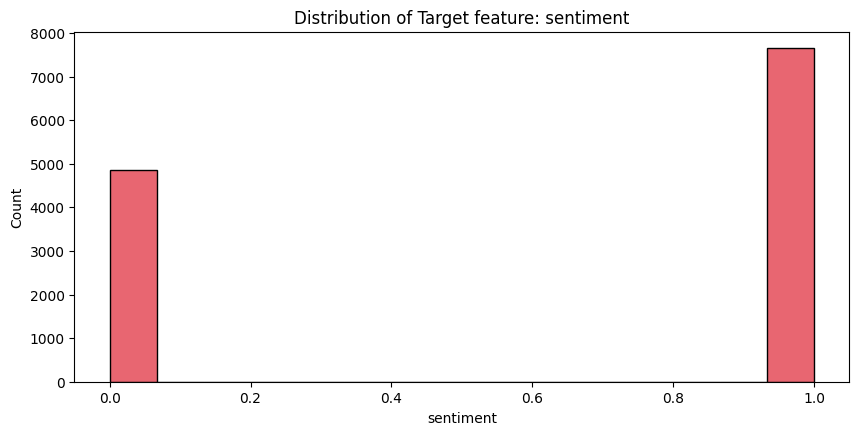

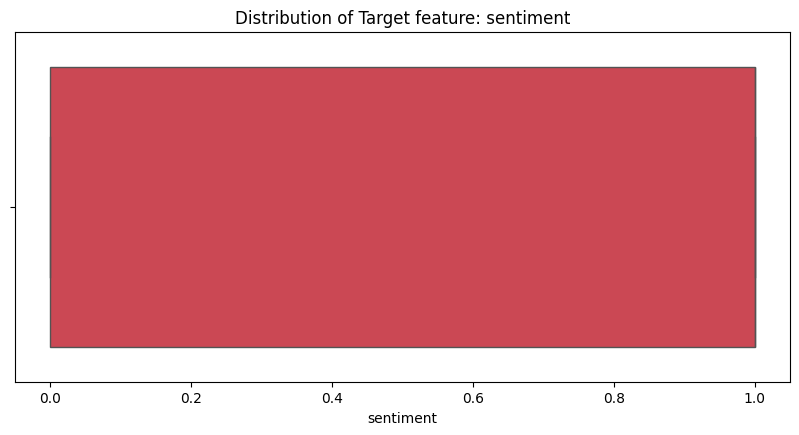

In [21]:
data_visualization.distribution_of_target_feature()

In [22]:
X = df['content'].values
y = df['sentiment'].values

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [23]:
max_len = 300

tokenizer = Text_Tokenization(nlp)

X_train = tokenizer.tokenize(x_train,max_len = max_len,Vocab = None)
vocab = tokenizer.vocab

X_test = tokenizer.tokenize(x_test,max_len = max_len,Vocab = vocab)

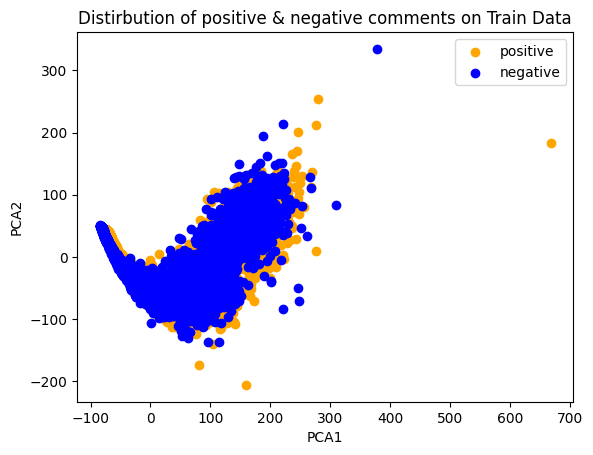

In [24]:
pca = PCA(n_components = 2)

positive = X_train[np.argwhere(y_train == 1)].squeeze()
negative = X_train[np.argwhere(y_train == 0)].squeeze()

positive_2d = pca.fit_transform(positive)
negative_2d = pca.fit_transform(negative)

plt.scatter(positive_2d[:,0],positive_2d[:,1],color = 'orange',label = 'positive')
plt.scatter(negative_2d[:,0],negative_2d[:,1],color = 'blue',label = 'negative')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Distirbution of positive & negative comments on Train Data')
plt.legend()
plt.show()

In [25]:
logistic_regression = LogisticRegression()
logistic_regression_params = None

naive_bayes = GaussianNB()
naive_bayes_params = None

svc = SVC()
svc_params = None

decision_tree = DecisionTreeClassifier()
decision_tree_params = [{'criterion': ['gini','entropy'], 'max_depth': [5,15,30,50,100], 'min_samples_split': [1,5,30]}]

random_forest = RandomForestClassifier()
random_forest_params = None

xgb_classifier = XGBClassifier()
xgb_classifier_params = None

models = [logistic_regression,naive_bayes,svc,decision_tree,random_forest,xgb_classifier]
params = [logistic_regression_params,naive_bayes_params,svc_params,decision_tree_params,random_forest_params,xgb_classifier_params]
metric = accuracy

In [26]:
Optimal = Optimal_model(models,metric,X_train,y_train,X_test,y_test,params = params)

Optimal.fit()
optimal_model = Optimal.optimal()


Model: LogisticRegression()
Trainer: <__main__.Train_model object at 0x14784dd90>
Model: LogisticRegression()
X for train n_samples: 9468
X for train n_features: 300



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<function accuracy_score at 0x1384f8f40> on Train Data: 0.6078369243768483
<function accuracy_score at 0x1384f8f40> on Test Data: 0.5878378378378378



Model: GaussianNB()
Trainer: <__main__.Train_model object at 0x147fbe690>
Model: GaussianNB()
X for train n_samples: 9468
X for train n_features: 300

<function accuracy_score at 0x1384f8f40> on Train Data: 0.4050485847063794
<function accuracy_score at 0x1384f8f40> on Test Data: 0.3999155405405405



Model: SVC()
Trainer: <__main__.Train_model object at 0x14783f350>
Model: SVC()
X for train n_samples: 9468
X for train n_features: 300

<function accuracy_score at 0x1384f8f40> on Train Data: 0.7299324038867765
<function accuracy_score at 0x1384f8f40> on Test Data: 0.5975506756756757



Model: DecisionTreeClassifier()
Trainer: <__main__.Train_model object at 0x148003c90>
Model: DecisionTreeClassifier()
X for train n_samples: 9468
X for train n_features: 300

<function accuracy_score at 0x1384f8f40> on Train Data: 0.9890156316011829
<funct

In [27]:
review = df['content'].iloc[72]

Predict(review,optimal_model)

Prediction: [0]
Thanks to your stupid update I lost ALL of my appointment dates... Terrible garbage. - negative


'negative'